<a href="https://colab.research.google.com/github/KazukiHirata-sun/ai_project_dev_2022/blob/main/section_3/Image_search_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Search using CLIP
[OpenAI](https://openai.com/) has released [CLIP](https://github.com/openai/CLIP), a general-purpose image classification model that has been trained with 400 million pairs of images and text describing the images. 

Use CLIP to create a text-based search system for the images to find among a large number of images.

## Downlod CLIP and datasets

The images used for the search are taken from [CelebA](https://paperswithcode.com/dataset/celeba) (a dataset of famous facial images), 5,000 of which are downloaded from Google Drive.

In [ ]:
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html 

# CLIP
! git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

! pip install ftfy regex
import clip
model, preprocess = clip.load('ViT-B/32', jit=True)  
model = model.eval()  

# Download of images
! pip install --upgrade gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1xIYYYzw9aZhjhyjMM12nz4XjnWUzpp6v', 'img.zip', quiet=False)
! unzip img.zip

## installtion of requrired module

In [18]:
import torch
import numpy as np
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data preprocessing
Read one png image at a time from the img folder, adjust the size to 224 x 224.

Then convert to tensor and normalize.

In [ ]:
preprocess = Compose([
    Resize(224, interpolation=Image.BICUBIC),
    CenterCrop(224),
    ToTensor()
])
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

images =[]
files = glob.glob('./img/*.png')
files.sort()

for i, file in enumerate(tqdm(files)):
      image = preprocess(Image.open(file).convert("RGB"))
      images.append(image)

image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

## Calculation of COS similarity between image and text
To retrieve images that match the text, the feature vectors of each image and text are extracted and the cosine similarity is calculated.

In [20]:
def cos_similarity_calculate(image, text):
  # Extract feature vectors
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True) 

  # Calculate
  text_probs = torch.cosine_similarity(image_features, text_features)

  return text_probs

## Show Serch Result
The results of the COS similarity calculation for 5,000 images are stored, and the image files in the index corresponding to the TOP 3 are displayed.

In [21]:
def show_search_results(text_probs):
  # Serching Text
  print('text = ', text)
  print()

  # Sort
  x = np.argsort(-text_probs.cpu(), axis=0)

  # Display TOP3 imags
  fig = plt.figure(figsize=(30, 40))
  for i in range(3):
    name = str(x[i].item()).zfill(6)+'.png'
    img = Image.open('./img/'+name)    
    images = np.asarray(img)
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    image_plt = np.array(images)
    ax.imshow(image_plt)
    cos_value = round(text_probs[x[i].item()].item(), 3)
    ax.set_xlabel(cos_value, fontsize=12)               
  plt.show()
  plt.close()

## Run

In [22]:
#@markdown ###**Search bar:**
text = 'He is handsome Japanese guy with glasses'  #@param{type: 'string'}

text =  He is handsome Japanese guy with glasses



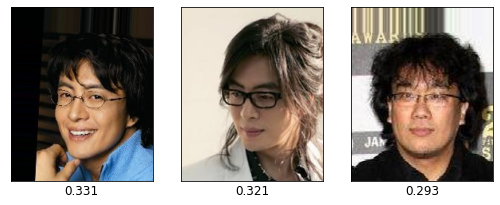

In [23]:
text_input = clip.tokenize(text)
text_input = text_input.cuda()

text_probs = cos_similarity_calculate(image_input, text_input)
show_search_results(text_probs)